## PyAPDL example for MDSI project
- This is the example code of using harmonic analysis to measure FRFs of the building at designated points.

- The detailed information of building geometry please check: GAB\ANSYS_Building_model\ANSYS Model.pdf.

- The documentation of PyAPDL please see [MAPDL command](https://mapdl.docs.pyansys.com/version/stable/mapdl_commands/index.html).

- **WARNING**: From my experience, it is better to first build the whole model and run the simulation using the original APDL in ANSYS. If everything works well, then transfer it to PyAPDL. I found that sometimes the numbering of labels of the line/area/node/elem are different when visualizing in PyAPDL using the VTK package compared to visualizing in the ANSYS window. However, the numbering in the ANSYS would be the correct one; this will lead to the problem that you might select the wrong item when using ```LSEL/ASEL/NSEL/ESEL``` commands or BOOLEAN actions such as ```ASBA``` command in PyAPDL directly. Therefore, the current best way is to build the model in APDL, ensure there is no wrong selection of items, and then use the same numbering shown in APDL to PyAPDL. If using the numbering  of labels shown in PyAPDL returned by ```LPLOT``` …etc , please double-check that you didn't select the wrong one. This can be checked by the command ```LPLOT,S,LINE, ,<numbering selected>``` …etc.

- **WARNING**: As the warning message returned, ```DMPART``` command might not be valided in new version of ANSYS, current version is 2021 R2. This command will be removed in the furture, still try to find better way to define the damping ratio

Author: Wei-Teng Kao (ge32gak@mytum.de)

## Initialization

For detailed information of launching PyAPDL please see [User guide](https://mapdl.docs.pyansys.com/version/stable/user_guide/index.html)

In [1]:
# C:\Users\v196m\AppData\Local\Temp

# Import the PyANSYS lib and other python lib
from ansys.mapdl.core import launch_mapdl
import matplotlib.pyplot as plt
import numpy as np

# Initialized the PyAPDL class and define num of cores for simluaiton by var: nproc.
# For teaching license, max number of cores = 4 
mapdl = launch_mapdl(nproc=4)

# Increase the maximum number of warning and error messages written to the error file (file.ERR) per command
# Not necessary, but by re-define the number of error can be written, it will show the message where the file0.err located
# file0.err file is important for debuging. 
# Potential path of file0.err is: C:\Users\<user_name>\AppData\Local\Temp\ansys_tmwcbnjkgj\file0.err 
mapdl.nerr(10000)


NUMBER OF DISPLAYED ERRORS ALLOWED PER COMMAND=              10000
 NUMBER OF ERRORS ALLOWED PER COMMAND BEFORE ANSYS ABORT=     10000
 ABORT LEVEL KEY= -1
 ALL ERRORS WRITTEN TO C:\Users\v196m\AppData\Local\Temp\ansys_tixaryijsw\file0.err                                                                                                                                                                                                        
 DO NOT TERMINATE /INPUT UPON FIRST ERROR

In [16]:
# Using the cammand for clearing the database
# Equivalent APDL command: /CLEAR
mapdl.clear()

## PREP7

#### PREP7 setup

Setting all the vars using python manner
- Setting the vars for controling PREP7, SOLU, and POST26.
- Setting the geometry information
- Setting the material properties

In [26]:
import numpy as np
bool_check_real_shape = 0 # Display the model in define thickness 

# PREP setting
bool_inner = 1
bool_stair = 1      # Both bool_inner = 1 and bool_stair = 1, then stair will be built
bool_SSI   = 1      # MATRIX27 soil-structure interection
elem_size  = 0.4    #[m]


# SOLU setting
Solu_type = 6       # Solu_type: if 2 = Modal, 3 = Harmonic, 4 = transient, 5 = Hammer_testing_Full, 6 = Hammer_testing_MSUP
Star_Freq = 0.001   # [Hz]
End_Freq  = 50     # [Hz]
Freq_Incr = 1.0     # [Hz]  Only use for calculate num of step, however, the final num of step might be different due to auto-process
N_modes   = 30      # Only use for Solu_typ = 2 and 6, if Solu_typ = 6, using small number of N_modes might lead to ROM due to less number of modal detected.
Damping_ratio = 0.05 
excitation_node = 4152 # used for Solu_typ = 5 or 6, the location of excitation point.

# POST setting
bool_write_result_csv = 1 # if bool_write_result_csv = 1, The POST26 results will be written as csv and save in designated folder.


#*************************** Geometry information ***************************#
#
#height          = 3.37  #[m]
height          = 4  #[m]
n_storeys       = 3     #[m]


#*************************** Material properties ***************************#
#
# Assume the column_eg (BEAM element) in EG has the same property as inner wall (SHELL element)
# Thickness [m]-----------------------------------------------
#t_slab          = 0.8
#t_corridor      = 0.8
#t_ground        = 0.05
#t_edge_wall     = 0.4
#t_inner_wall    = 0.4
#t_stair         = 0.468

#
t_slab          = 0.6 
t_corridor      = 0.8
t_ground        = 0.05
t_edge_wall     = 0.2
t_inner_wall    = 0.2
t_stair         = 0.468

# Young's modulus [N/m^2] -----------------------------------------------
E_slab          = 20e9  
E_corridor      = 20e9
E_ground        = 20e9
E_edge_wall     = 20e9
E_inner_wall    = 20e9
E_stair         = 20e9

# Poisson's ratio [-] -----------------------------------------------
nu_slab         = 0.27  
nu_corridor     = 0.27
nu_ground       = 0.27
nu_edge_wall    = 0.27
nu_inner_wall   = 0.27
nu_stair        = 0.27

# Density [kg/m^3] -----------------------------------------------
rho_slab        = 2300  
rho_corridor    = 2300 
rho_ground      = 2300 
rho_edge_wall   = 2300 
rho_inner_wall  = 2300 
rho_stair       = 2300


#-----------------------Soil properties------------------------#
Vs_soil         = 450          # Shear wave velocity [m/s]
Rho_soil        = 2.3e3        # Soil density [kg/m^3]
Nu_soil         = 0.33         # Soil Poisson's Ratio [-]
L_f             = elem_size/2  # Foundation half-length [m]
B_f             = elem_size/2  # Foundation half-width [m]

#### PREP7 geometry define

In [27]:
mapdl.clear()
coord_x = np.array([0.0000, 0.4400, 2.2100, 3.4100, 5.1800, 6.3800, 8.1500, 9.3500, 11.120, 12.320, 14.092, 15.290, 17.060, 18.471, 17.584, 16.553, 15.799, 14.768, 14.014, 12.983,12.398, 12.229, 11.199, 10.444, 9.4140, 8.9870, 8.6590, 7.6290, 7.2020, 5.5550,4.4430, 3.1420, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.2600, 4.5900, 8.7900,4.5900, 4.5900, 4.5900, 4.5900, 4.5900, 2.9230, 2.9230, 1.4700, 1.4700, 2.3600,3.2600, 5.6620, 0.0000, 2.2100, 2.2100, 3.2600, 1.1500])
coord_y = np.array([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,0.0000, 0.0000, 0.0000, 0.0000, 1.0970, 2.3730, 3.3060, 4.5820, 5.5150, 6.7910,  7.5150, 7.7240, 9.0000, 9.9330, 11.209, 11.737, 12.142, 13.418, 13.946, 15.984,17.361, 18.970, 18.970, 16.120, 11.700, 10.450, 4.6000, 4.6000, 4.6000, 4.6000,5.8500, 8.1850, 9.6100, 10.860, 11.836, 13.870, 16.120, 16.120, 13.870, 10.450,9.3360, 8.9700, 13.870, 3.1000, 4.6000, 5.7500, 10.450])
num_kp  = len(coord_x)


# Start the preprocessor PREP7
mapdl.prep7()
# Specify the unit
mapdl.units("SI") 

# Create the keypoint first using the k() method (Equivalent APDL command: K)
for i_storey in range(n_storeys+1):
    for i_kp in range(num_kp):
        n_kp = i_storey*num_kp +  i_kp + 1
        n_coor = i_kp
        x_kp = coord_x[n_coor]
        y_kp = coord_y[n_coor]
        mapdl.k(n_kp, x_kp, y_kp,i_storey*height)


for i_storey in range(n_storeys-1):
    num_acc = ((n_storeys+1)*num_kp) + (i_storey*num_kp)
    mapdl.k( 1 + num_acc, 0.0000, 8.4500,11*(height/18) +(i_storey)*height)
    mapdl.k( 2 + num_acc, 0.0000, 7.3750,11*(height/18) +(i_storey)*height)
    mapdl.k( 3 + num_acc, 0.0000, 5.7500, 4*(height/18) +(i_storey)*height)
    mapdl.k( 4 + num_acc, 0.0000, 4.6000, 4*(height/18) +(i_storey)*height)
    mapdl.k( 5 + num_acc, 1.1500, 4.6000, 4*(height/18) +(i_storey)*height)
    mapdl.k( 6 + num_acc, 1.9600, 4.6000,        0.0000 +(i_storey)*height)
    mapdl.k( 7 + num_acc, 1.9600, 5.7500,        0.0000 +(i_storey)*height)
    mapdl.k( 8 + num_acc, 1.1500, 5.7500, 4*(height/18) +(i_storey)*height)
    mapdl.k( 9 + num_acc, 1.1500, 7.3750,11*(height/18) +(i_storey)*height)
    mapdl.k(10 + num_acc, 1.1500, 8.4500,11*(height/18) +(i_storey)*height)
    mapdl.k(11 + num_acc, 1.1500, 10.450,        height +(i_storey)*height)
    mapdl.k(12 + num_acc, 3.2600, 5.7500,        0.0000 +(i_storey)*height)




#### PREP7 Model building

In [ ]:
# Create the Area using the a() method (Equivalent APDL command: A)
for i_storey in range(n_storeys+1):
    # AREA 1
    A_kp_1 = 34 + (i_storey*num_kp)
    A_kp_2 = 53 + (i_storey*num_kp)
    A_kp_3 = 49 + (i_storey*num_kp)
    A_kp_4 = 48 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4)
    #
    # AREA 2
    A_kp_1 = 31 + (i_storey*num_kp)
    A_kp_2 = 32 + (i_storey*num_kp)
    A_kp_3 = 33 + (i_storey*num_kp)
    A_kp_4 = 34 + (i_storey*num_kp)
    A_kp_5 = 48 + (i_storey*num_kp)
    A_kp_6 = 47 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6)
    #
    # AREA 3
    A_kp_1 = 30 + (i_storey*num_kp)
    A_kp_2 = 31 + (i_storey*num_kp)
    A_kp_3 = 47 + (i_storey*num_kp)
    A_kp_4 = 48 + (i_storey*num_kp)
    A_kp_5 = 49 + (i_storey*num_kp)
    A_kp_6 = 46 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6)
    #
    # AREA 4
    A_kp_1 = 21 + (i_storey*num_kp)
    A_kp_2 = 22 + (i_storey*num_kp)
    A_kp_3 = 23 + (i_storey*num_kp)
    A_kp_4 = 24 + (i_storey*num_kp)
    A_kp_5 = 25 + (i_storey*num_kp)
    A_kp_6 = 26 + (i_storey*num_kp)
    A_kp_7 = 52 + (i_storey*num_kp)
    A_kp_8 = 42 + (i_storey*num_kp)
    A_kp_9 = 41 + (i_storey*num_kp)
    A_kp_10= 39 + (i_storey*num_kp)
    A_kp_11= 40 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6, A_kp_7, A_kp_8, A_kp_9, A_kp_10, A_kp_11)
    #
    # AREA 5
    A_kp_1 = 26 + (i_storey*num_kp)
    A_kp_2 = 27 + (i_storey*num_kp)
    A_kp_3 = 28 + (i_storey*num_kp)
    A_kp_4 = 29 + (i_storey*num_kp)
    A_kp_5 = 45 + (i_storey*num_kp)
    A_kp_6 = 44 + (i_storey*num_kp)
    A_kp_7 = 43 + (i_storey*num_kp)
    A_kp_8 = 42 + (i_storey*num_kp)
    A_kp_9 = 52 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6, A_kp_7, A_kp_8, A_kp_9)
    #
    # AREA 6
    A_kp_1 = 10 + (i_storey*num_kp)
    A_kp_2 = 11 + (i_storey*num_kp)
    A_kp_3 = 12 + (i_storey*num_kp)
    A_kp_4 = 13 + (i_storey*num_kp)
    A_kp_5 = 14 + (i_storey*num_kp)
    A_kp_6 = 15 + (i_storey*num_kp)
    A_kp_7 = 16 + (i_storey*num_kp)
    A_kp_8 = 17 + (i_storey*num_kp)
    A_kp_9 = 18 + (i_storey*num_kp)
    A_kp_10= 19 + (i_storey*num_kp)
    A_kp_11= 20 + (i_storey*num_kp)
    A_kp_12= 21 + (i_storey*num_kp)
    A_kp_13= 40 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6, A_kp_7, A_kp_8, A_kp_9, A_kp_10, A_kp_11, A_kp_12, A_kp_13)
    #
    # AREA 7 
    A_kp_1 = 3 + (i_storey*num_kp)
    A_kp_2 = 4 + (i_storey*num_kp)
    A_kp_3 = 5 + (i_storey*num_kp)
    A_kp_4 = 6 + (i_storey*num_kp)
    A_kp_5 = 7 + (i_storey*num_kp)
    A_kp_6 = 8 + (i_storey*num_kp)
    A_kp_7 = 9 + (i_storey*num_kp)
    A_kp_8 = 10 + (i_storey*num_kp)
    A_kp_9 = 40 + (i_storey*num_kp)
    A_kp_10= 39 + (i_storey*num_kp)
    A_kp_11= 38 + (i_storey*num_kp)
    A_kp_12= 55 + (i_storey*num_kp)
    A_kp_13= 54 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6, A_kp_7, A_kp_8, A_kp_9, A_kp_10, A_kp_11, A_kp_12, A_kp_13)
    #
    # AREA 8
    A_kp_1 = 1 + (i_storey*num_kp)
    A_kp_2 = 2 + (i_storey*num_kp)
    A_kp_3 = 3 + (i_storey*num_kp)
    A_kp_4 = 54+ (i_storey*num_kp)
    A_kp_5 = 55+ (i_storey*num_kp)
    A_kp_6 = 37+ (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6)
    #
    # AREA 9 
    A_kp_1 = 37 + (i_storey*num_kp)
    A_kp_14 =55 + (i_storey*num_kp)
    A_kp_2 = 38 + (i_storey*num_kp)
    A_kp_3 = 56 + (i_storey*num_kp)
    A_kp_4 = 41 + (i_storey*num_kp)
    A_kp_5 = 42 + (i_storey*num_kp)
    A_kp_6 = 43 + (i_storey*num_kp)
    A_kp_7 = 44 + (i_storey*num_kp)
    A_kp_8 = 45 + (i_storey*num_kp)
    A_kp_9 = 46 + (i_storey*num_kp)
    A_kp_10= 49 + (i_storey*num_kp)
    A_kp_11= 53 + (i_storey*num_kp)
    A_kp_12= 35 + (i_storey*num_kp)
    A_kp_13= 36 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_14, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6, A_kp_7, A_kp_8, A_kp_9, A_kp_10, A_kp_11, A_kp_12, A_kp_13)
    #
    # AREA 10
    A_kp_1 = 38 + (i_storey*num_kp)
    A_kp_2 = 39 + (i_storey*num_kp)
    A_kp_3 = 41 + (i_storey*num_kp)
    A_kp_4 = 56 + (i_storey*num_kp)
    mapdl.a(A_kp_1, A_kp_2, A_kp_3, A_kp_4)
    #
    # AREA 11
    if i_storey <n_storeys and i_storey != 0:
        A_kp_1 = 37 + (i_storey*num_kp)
        A_kp_2 = 55 + (i_storey*num_kp)
        A_kp_3 = 38 + (i_storey*num_kp)
        A_kp_4 = 56 + (i_storey*num_kp)
        A_kp_5 = 51 + (i_storey*num_kp)
        A_kp_6 = 50 + (i_storey*num_kp)
        A_kp_7 = 57 + (i_storey*num_kp)
        A_kp_8 = 36 + (i_storey*num_kp)
        mapdl.a( A_kp_1, A_kp_2, A_kp_3, A_kp_4, A_kp_5, A_kp_6, A_kp_7, A_kp_8)


num_count = (n_storeys*num_kp)
mapdl.a( 29+num_count, 30+num_count, 46+num_count, 45+num_count)
#
# Boolean the area using the asba() method (Equivalent APDL command: ASBA)
aout1 = mapdl.asba(19, 21)
aout2 = mapdl.asba(30, 32)



# Select the area using the asel() method (Equivalent APDL command: ASEL)
mapdl.asel('ALL')
mapdl.asel('S', 'AREA', '', 44)
mapdl.asel('A', 'AREA', '', 19)
mapdl.asel('A', 'AREA', '', 41)
mapdl.asel('A', 'AREA', '', 42)
mapdl.asel('A', 'AREA', '', 31)
mapdl.asel('A', 'AREA', '', 20)
mapdl.cm('corridor_floor', 'AREA')
#mapdl.aplot(show_area_numbering=True, color_areas=True)
#mapdl.asel('S', 'AREA', '', 'corridor_floor')
mapdl.asel('ALL')






for i_storey in range(1,n_storeys+1):
    kp_id_2 = 14
    for i_kp in range(1,kp_id_2+1):
        if i_kp % 2 != 0:
            A_kp_1 = i_kp + ((i_storey-1)*num_kp)
            A_kp_2 = i_kp + 1 + ((i_storey-1)*num_kp)
            A_kp_3 = i_kp + 1 + ((i_storey)*num_kp)
            A_kp_4 = i_kp + ((i_storey)*num_kp)
            mapdl.a( A_kp_1, A_kp_2, A_kp_3, A_kp_4)

    kp_id_3 = 21
    for i_kp in range(kp_id_2,kp_id_3+1):
        if i_kp % 2 == 0:
                A_kp_1 = i_kp + ((i_storey-1)*num_kp)
                A_kp_2 = i_kp + 1 + ((i_storey-1)*num_kp)
                A_kp_3 = i_kp + 1 + ((i_storey)*num_kp)
                A_kp_4 = i_kp + ((i_storey)*num_kp)
                mapdl.a( A_kp_1, A_kp_2, A_kp_3, A_kp_4)
    #
    kp_id_4 = 26
    for i_kp in range(kp_id_3,kp_id_4+1):
        if i_kp % 2 != 0:
                A_kp_1 = i_kp + ((i_storey-1)*num_kp)
                A_kp_2 = i_kp + 1 + ((i_storey-1)*num_kp)
                A_kp_3 = i_kp + 1 + ((i_storey)*num_kp)
                A_kp_4 = i_kp + ((i_storey)*num_kp)
                mapdl.a( A_kp_1, A_kp_2, A_kp_3, A_kp_4)
    #
    kp_id_5 = 29
    for i_kp in range(kp_id_4,kp_id_5+1):
        if i_kp % 2 == 0:
                A_kp_1 = i_kp + ((i_storey-1)*num_kp)
                A_kp_2 = i_kp + 1 + ((i_storey-1)*num_kp)
                A_kp_3 = i_kp + 1 + ((i_storey)*num_kp)
                A_kp_4 = i_kp + ((i_storey)*num_kp)
                mapdl.a( A_kp_1, A_kp_2, A_kp_3, A_kp_4)
    #
    # Wall without window
    #
    for i_kp in range(30,34):
        A_kp_1 = i_kp + ((i_storey-1)*num_kp)
        A_kp_2 = i_kp + 1 + ((i_storey-1)*num_kp)
        A_kp_3 = i_kp + 1 + ((i_storey)*num_kp)
        A_kp_4 = i_kp + ((i_storey)*num_kp)
        mapdl.a( A_kp_1, A_kp_2, A_kp_3, A_kp_4)
    #
    # Aufzug
    #
    if i_storey != 1:
        mapdl.a( 29+ ((i_storey-1)*num_kp), 30+ ((i_storey-1)*num_kp), 30+ ((i_storey)*num_kp), 29+ ((i_storey)*num_kp))
    #
    mapdl.a( 34 + ((i_storey-1)*num_kp), 53 + ((i_storey-1)*num_kp), 53+ ((i_storey)*num_kp), 34+ ((i_storey)*num_kp))
    mapdl.a( 53 + ((i_storey-1)*num_kp), 35 + ((i_storey-1)*num_kp), 35+ ((i_storey)*num_kp), 53+ ((i_storey)*num_kp))
    mapdl.a( 36 + ((i_storey-1)*num_kp), 37 + ((i_storey-1)*num_kp), 37+ ((i_storey)*num_kp), 36+ ((i_storey)*num_kp))
    mapdl.a( 37 + ((i_storey-1)*num_kp),  1 + ((i_storey-1)*num_kp),  1+ ((i_storey)*num_kp), 37+ ((i_storey)*num_kp))
    #


# Create the group of selected items using the cm() method (Equivalent APDL command: CM)
mapdl.cm('outside_wall', 'AREA')

if bool_inner and bool_stair:
    for i_storey in range(n_storeys-1):
        #
        num_acc = ((n_storeys+1)*num_kp) + (i_storey*num_kp)
        #
        mapdl.a( 36 +  ((i_storey+1)*num_kp), 1 + num_acc , 10 + num_acc , 57+((i_storey+1)*num_kp) )
        mapdl.a(  1 +                num_acc, 2 + num_acc ,  9 + num_acc , 10 + num_acc)
        mapdl.a(  2 +                num_acc, 3 + num_acc ,  8 + num_acc ,  9 + num_acc)
        mapdl.a(  3 +                num_acc, 4 + num_acc ,  5 + num_acc ,  8 + num_acc)
        mapdl.a(  5 +                num_acc, 6 + num_acc ,  7 + num_acc ,  8 + num_acc)
        mapdl.a(  6+num_acc    , 38+((i_storey)*num_kp),  12 + num_acc, 7 + num_acc)
    mapdl.asba(9,121,'','DELETE','KEEP')
    # Merges coincident or equivalently defined items using the nummrg() method (Equivalent APDL command: NUMMRG)
    mapdl.nummrg('kp')  


if bool_inner:
    for i_storey in range(n_storeys):
        # Treppen Haus
        mapdl.a(37+(i_storey*num_kp), 38+(i_storey*num_kp), 38+((i_storey+1)*num_kp), 37+((i_storey+1)*num_kp))
        # Aufzug
        mapdl.a(45+(i_storey*num_kp), 29+(i_storey*num_kp), 29+((i_storey+1)*num_kp), 45+((i_storey+1)*num_kp))
        mapdl.a(46+(i_storey*num_kp), 30+(i_storey*num_kp), 30+((i_storey+1)*num_kp), 46+((i_storey+1)*num_kp))
        # Teekueche 
        mapdl.a(47+(i_storey*num_kp), 31+(i_storey*num_kp), 31+((i_storey+1)*num_kp), 47+((i_storey+1)*num_kp))
        # Technik
        mapdl.a(49+(i_storey*num_kp), 48+(i_storey*num_kp), 48+((i_storey+1)*num_kp), 49+((i_storey+1)*num_kp))
        mapdl.a(48+(i_storey*num_kp), 34+(i_storey*num_kp), 34+((i_storey+1)*num_kp), 48+((i_storey+1)*num_kp))
        #
    #
    # EG config
    #
    #A, 38, 39, 39+(1*num_kp), 38+(1*num_kp)
    mapdl.a( 41, 42, 42+(1*num_kp), 41+(1*num_kp))
    mapdl.a( 52, 26, 26+(1*num_kp), 52+(1*num_kp))
    mapdl.lsel('NONE')
    mapdl.l(39, 39+(1*num_kp))# BEAM elemetn (only this one)   
    mapdl.cm('column_eg', 'LINE')
    mapdl.lsel('ALL')
    #
    # 1 OG config
    #
    #mapdl.a( 39+(1*num_kp), 40+(1*num_kp), 40+(2*num_kp), 39+(2*num_kp))
    #mapdl.a( 40+(1*num_kp), 21+(1*num_kp), 21+(2*num_kp), 40+(2*num_kp))
    #mapdl.a( 40+(1*num_kp), 10+(1*num_kp), 10+(2*num_kp), 40+(2*num_kp))
    mapdl.a(  3+(1*num_kp), 54+(1*num_kp), 54+(2*num_kp),  3+(2*num_kp))
    #
    # 1, 2 OG config
    #
    for i_storey in range(1,n_storeys):
        mapdl.a( 41+(i_storey*num_kp), 42+(i_storey*num_kp), 42+((i_storey+1)*num_kp), 41+((i_storey+1)*num_kp))
        mapdl.a( 42+(i_storey*num_kp), 43+(i_storey*num_kp), 43+((i_storey+1)*num_kp), 42+((i_storey+1)*num_kp))
        mapdl.a( 44+(i_storey*num_kp), 45+(i_storey*num_kp), 45+((i_storey+1)*num_kp), 44+((i_storey+1)*num_kp))
    #
    # 2 OG config
    #
    mapdl.a( 38+(2*num_kp), 39+(2*num_kp), 39+(3*num_kp), 38+(3*num_kp))





 








#************************* Creating group for element assignemnt **************************#
#
#
# Group floor slab id-----------------------------------------------
mapdl.asel('NONE')
for i_storey in range(1, n_storeys+1):
    mapdl.asel('A','LOC','Z',i_storey*height)
               
mapdl.asel('U','AREA','','corridor_floor')    # Delete unnecessary wall which is selected auto.
mapdl.asel('U','LOC','Y', (5.75+4.6)/2)
mapdl.cm('slab_floor','AREA')
mapdl.asel('ALL')
#
#
# Group floor Ground id-----------------------------------------------
mapdl.asel('ALL')
mapdl.asel('S','LOC','Z',0)
mapdl.cm('ground_floor','AREA')
mapdl.asel('ALL')
#
#
# Group Edge of building id-----------------------------------------------
mapdl.asel('S','AREA','','outside_wall ')
mapdl.asel('U','AREA','','slab_floor')
mapdl.asel('U','AREA','','ground_floor')
mapdl.asel('U','AREA','','corridor_floor ')
mapdl.cm('outside_wall','AREA')
mapdl.asel('ALL')
#
#
# Group Inner wall id-----------------------------------------------
if bool_inner:
    mapdl.asel('NONE')
    for i_storey in range(n_storeys):
        mapdl.asel('A','LOC','Z', i_storey*height + (height)/2)
    mapdl.asel('U','AREA','','outside_wall') 
    mapdl.cm('inner_wall','AREA')
    mapdl.asel('ALL')
    #
    # Group Stairs id-----------------------------------------------
    if bool_stair:
        mapdl.asel('S','LOC','X', 1.15/2)
        mapdl.asel('A','LOC','Y', (5.75+4.6)/2)
        mapdl.asel('U','AREA','','corridor_floor')
        mapdl.asel('U','AREA','',121)
        mapdl.asel('U','AREA','',10)
        mapdl.cm('stair_floor','AREA')
        mapdl.asel('ALL')



#*************************** Material properties ***************************#
# Define the Material properties  (Equivalent APDL command: ET/ SECTYPE/ SECDATA/ MP/ AATT)
mapdl.et(1, "SHELL181 ")
mapdl.sectype(1,'SHELL')
mapdl.secdata(t_slab)
mapdl.mp('EX',1,E_slab)
mapdl.mp('PRXY',1,nu_slab)
mapdl.mp('DENS',1,rho_slab)
mapdl.asel('S','AREA','','slab_floor')
mapdl.aatt(1,0,1,'',1)
mapdl.asel('ALL')

mapdl.et(2, "SHELL181 ")
mapdl.sectype(2,'SHELL')
mapdl.secdata(t_corridor)
mapdl.mp('EX',2,E_corridor)
mapdl.mp('PRXY',2,nu_corridor)
mapdl.mp('DENS',2,rho_corridor)
mapdl.asel('S','AREA','','corridor_floor')
mapdl.aatt(2,0,2,'',2)
mapdl.asel('ALL')

mapdl.et(3, "SHELL181 ")
mapdl.sectype(3,'SHELL')
mapdl.secdata(t_ground)
mapdl.mp('EX',3,E_ground)
mapdl.mp('PRXY',3,nu_ground)
mapdl.mp('DENS',3,rho_ground)
mapdl.asel('S','AREA','','ground_floor')
mapdl.aatt(3,0,3,'',3)
mapdl.asel('ALL')

mapdl.et(4,"SHELL181 ")
mapdl.sectype(4,'SHELL')
mapdl.secdata(t_edge_wall)
mapdl.mp('EX',4,E_edge_wall)
mapdl.mp('PRXY',4,nu_edge_wall)
mapdl.mp('DENS',4,rho_edge_wall)
mapdl.asel('S','AREA','','outside_wall')
mapdl.aatt(4,0,4,'',4)
mapdl.asel('ALL')

if bool_inner:
    mapdl.et(5,"SHELL181 ")
    mapdl.sectype(5,'SHELL')
    mapdl.secdata(t_inner_wall)
    mapdl.mp('EX',5,E_inner_wall)
    mapdl.mp('PRXY',5,nu_inner_wall)
    mapdl.mp('DENS',5,rho_inner_wall)
    mapdl.asel('S','AREA','','inner_wall')
    mapdl.aatt(5,0,5,'',5)
    mapdl.asel('ALL')

    if bool_stair:
        mapdl.et(6,"SHELL181 ")
        mapdl.sectype(6,'SHELL')
        mapdl.secdata(t_stair)
        mapdl.mp('EX',6,E_stair)
        mapdl.mp('PRXY',6,nu_stair)
        mapdl.mp('DENS',6,rho_stair)
        mapdl.asel('S','AREA','','stair_floor')
        mapdl.aatt(6,0,6,'',6)
        mapdl.asel('ALL')
    
    # WARNING!!! The latt command in PyAPDL and APDL are different!
    # In APDL,   Associates element attributes with the selected, unmeshed lines using LATT,7,0,7,-,-,-,7 -> 7 parameter to define
    # In PyAPDL, Associates element attributes with the selected, unmeshed lines using latt(7,0,7,'','',7)-> 6 parameter to define
    mapdl.et(7,"BEAM189")
    mapdl.sectype(7,'BEAM','RECT')
    mapdl.secoffset('CENT')
    mapdl.secdata(t_inner_wall,t_inner_wall)
    mapdl.mp('EX',7,E_inner_wall)
    mapdl.mp('PRXY',7,nu_inner_wall)
    mapdl.mp('DENS',7,rho_inner_wall)
    mapdl.lsel('S','LINE','','column_eg')
    mapdl.latt(7,0,7,'','',7)
    mapdl.lsel('ALL')




In [ ]:
# Visualization area selected, (Equivalent APDL command: APLOT)
mapdl.aplot(show_area_numbering=True, color_areas=True)

#### PREP7 - meshing and SSI

In [29]:
# Meshing
mapdl.lesize('ALL',elem_size)
mapdl.aesize('ALL',elem_size)
mapdl.amesh('ground_floor')
mapdl.nsel('S','LOC','Z',0)
mapdl.cm('ground_node','NODE')
mapdl.nsel('ALL')

if bool_SSI:
    #*************************** Define SSI properties ***************************##
    #   
    L1              =(4*L_f*B_f/3.14159)**0.5 	#sqrt(A_f/pi)[m]  #(from luco and wang, 1978)
    G               =(Vs_soil**2)*(Rho_soil)
    #
    #Parameters defined from Wolf,1997
    K_hor           = 8*G*L1/(2-Nu_soil)
    K_vert          = 4*G*L1/(1-Nu_soil)
    K_rock          = 8*G*(L1**3)/(3*(1-Nu_soil))
    K_tors          = 16*G*(L1**3)/3
    #
    #
    #Lumped Mass coefficient [kg] 
    M_Z             =((L1**2)/(Vs_soil**2))*0.27*K_vert	
    M_Y             =((L1**2)/(Vs_soil**2))*0.095*K_hor
    M_X             =((L1**2)/(Vs_soil**2))*0.095*K_hor
    Ix              = ((L1**2)/(Vs_soil**2))*0.24*K_rock	
    Iy              = ((L1**2)/(Vs_soil**2))*0.24*K_rock
    Iz              = ((L1**2)/(Vs_soil**2))*0.045*K_tors
    gamma_C_rock    = 0.3 / ( 1+ ((3*(1-Nu_soil)*Ix)/(8*L1**5*Rho_soil)) )
    gamma_C_tors    =(0.433/(1+((2*Iz)/(L1**5*Rho_soil))))*((Iz)/(L1**5*Rho_soil))**(0.5)
    C_hor           = L1*0.58*K_hor / Vs_soil
    C_vert          = L1*0.85*K_vert / Vs_soil
    C_rock          = L1*gamma_C_rock*K_rock/Vs_soil
    C_tors          = L1*gamma_C_tors*K_tors/Vs_soil
    #
    #
    #-Stiffness-------------------------
    Ka_11           = K_hor	
    Ka_22           = K_hor
    Ka_33           = K_vert					
    Ka_44           = K_rock		
    Ka_55           = K_rock	
    Ka_66           = K_tors
    Ka_15           = 0	
    Ka_24           = 0			
    #	
    #-damping--------------------------- 
    Ca_11           = C_hor	
    Ca_22           = C_hor
    Ca_33           = C_vert		
    Ca_44           = C_rock		
    Ca_55           = C_rock	
    Ca_66           = C_tors
    Ca_15           = 0
    Ca_24           = 0
    #
    #
    #
    mapdl.et(8, "MASS21", kop3=0)
    mapdl.type(8)
    mapdl.real(8)
    mapdl.r(8,M_X,M_Y,M_Z,Ix,Iy,Iz)
    #
    mapdl.et(9, "MATRIX27", kop1 = 1, kop2 = 0, kop3=4, kop4 = 1)
    mapdl.r(9,Ka_11,0,0,0,Ka_15,0)
    mapdl.rmore(-Ka_11,0,0,0,-Ka_15,0      )       # C7 to C12
    mapdl.rmore(Ka_22,0,Ka_24,0,0,0        )       # C13 to 18
    mapdl.rmore(-Ka_22,0,-Ka_24,0,0,Ka_33  )      	# C19 to 24
    mapdl.rmore(0,0,0,0,0,-Ka_33           )       # C25 to 30
    mapdl.rmore(0,0,0,Ka_44,0,0            )		# C31 to 36
    mapdl.rmore(0,-Ka_24,0,-Ka_44,0,0      )       # C37 to 42
    mapdl.rmore(Ka_55,0,-Ka_15,0,0,0       )       # C43 to 48
    mapdl.rmore(-Ka_55,0,Ka_66,0,0,0       )  		# C49 to 54
    mapdl.rmore(0,0,-Ka_66,Ka_11,0,0       )   	   # C55 to 60
    mapdl.rmore(0,Ka_15,0,Ka_22,0,Ka_24    )      	# C61 to 66
    mapdl.rmore(0,0,Ka_33,0,0,0 		   )		# C6_7 to 72
    mapdl.rmore(Ka_44,0,0,Ka_55,0,Ka_66    )      	# C73 to 78
    #
    mapdl.et(10, "MATRIX27", kop1 = 1, kop2 = 0, kop3=5, kop4 = 1)
    mapdl.r(10,Ca_11,0,0,0,Ca_15,0)           # C1 to C6
    mapdl.rmore(-Ca_11,0,0,0,-Ca_15,0)        # C7 to C12
    mapdl.rmore(Ca_22,0,Ca_24,0,0,0)          # C13 to 18
    mapdl.rmore(-Ca_22,0,-Ca_24,0,0,Ca_33)    # C19 to 24
    mapdl.rmore(0,0,0,0,0,-Ca_33)             # C25 to 30
    mapdl.rmore(0,0,0,Ca_44,0,0)              # C31 to 36
    mapdl.rmore(0,-Ca_24,0,-Ca_44,0,0)        # C37 to 42
    mapdl.rmore(Ca_55,0,-Ca_15,0,0,0)         # C43 to 48
    mapdl.rmore(-Ca_55,0,Ca_66,0,0,0)         # C49 to 54
    mapdl.rmore(0,0,-Ca_66,Ca_11,0,0)         # C55 to 60
    mapdl.rmore(0,Ca_15,0,Ca_22,0,Ca_24)      # C61 to 66
    mapdl.rmore(0,0,Ca_33,0,0,0)              # C67 to 72
    mapdl.rmore(Ca_44,0,0,Ca_55,0,Ca_66)      # C73 to 78
    #
    #
    n_count = mapdl.nsel('S','NODE','','ground_node')
    mapdl.ngen(2,len(n_count),'ground_node','','',0,0,-elem_size)
    mapdl.nsel('ALL')
    mapdl.nsel('S','LOC','Z',-elem_size)
    mapdl.cm('foundation_node','NODE')
    mapdl.nsel('ALL')
    mapdl.nummrg('NODE')
    #
    mapdl.knode('','ground_node')
    mapdl.nummrg('kp')
    mapdl.cmsel('ALL')
    mapdl.ksel('S','LOC','Z',0)
    mapdl.cm('ground_kp','KP')
    mapdl.cmsel('ALL')
    #
    mapdl.ksel('S','KP','','ground_kp')
    mapdl.katt(0,8,8)
    mapdl.ksel('ALL')
    #
    mapdl.nsel('ALL')
    mapdl.type(9)
    mapdl.real(9)
    mapdl.eintf('','','LOW',0,0,0,-elem_size,0)
    #
    mapdl.nsel('ALL')
    mapdl.type(10)
    mapdl.real(10)
    mapdl.eintf('','','LOW',0,0,0,-elem_size,0)
    mapdl.nsel('ALL')

mapdl.asel('ALL')
mapdl.asel('U','AREA','','ground_floor')
mapdl.cm('area_remained','AREA')
mapdl.asel('ALL')
mapdl.amesh('area_remained')
#
if bool_inner:
    mapdl.lmesh('column_eg')
#
if bool_SSI:
    mapdl.kmesh('ground_kp')
#
mapdl.nsel('ALL')
mapdl.esel('ALL')
mapdl.ksel('ALL')
mapdl.nummrg('ELEM')
mapdl.nummrg('NODE')
mapdl.nsel('ALL')


array([    1,     2,     3, ..., 13444, 13445, 13446])

In [13]:
mapdl.eplot(show_edges=True, smooth_shading=True, show_node_numbering=False)

Widget(value='<iframe src="http://localhost:56226/index.html?ui=P_0x1958a3ad0c0_1&reconnect=auto" class="pyvis…

## SOLU

#### For harmonic analysis:

- If your loading is force instead of displacement or acc, then you can use Mode-Superposition Harmonic Analysis Method by ```HROPT,MSUP``` and the result from Modal analysis, this method will accelerate your simulation a lot, please see [the example](https://www.ansystips.com/2017/08/harmonic-msup-using-multiple-solve.html), which provide a runable APDL code.

- WARNING: Also try Harmonic analysis using the [frequency-sweep Krylov method](https://mapdl.docs.pyansys.com/version/stable/examples/extended_examples/Krylov/krylov_example.html#krylov-example), however it seems like there are some unexpected bugs, the server terminate directly.

In [30]:
tol = 0.3


# Excitation point: Hammer 2.0 Pos1 (shaker)
mapdl.nsel('S','LOC','Z',height*2)
mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
print(nsel_id_1)
mapdl.nsel('ALL')


# Excitation point: Hammer 2.0 Pos2 (sensor)
mapdl.nsel('S','LOC','Z',height*2)
mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
print(nsel_id_2)
mapdl.nsel('ALL')

# Excitation point: Hammer 2.1 Pos1 (close to edge)
mapdl.nsel('S','LOC','Z',height*2)
mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
print(nsel_id_3)
mapdl.nsel('ALL')


# Apply the force on selected node
excitation_node = nsel_id_1[1]
print(excitation_node)




[5250 5251 5293]
[5343 5344]
[5782 5783]
5251


In [31]:
# Start the SOLUTION
# If you find your simultion is terminated with no reason, then check the error files: file0.err, 
# sometimes it won't return the error message directly in python's command window.
#

mapdl.run("/SOLU")
if Solu_type == 2:
    mapdl.antype(2)  
    mapdl.modopt('LANB',N_modes,Star_Freq,End_Freq,'','OFF' )
    mapdl.dmprat(Damping_ratio)	
    if bool_SSI:
        mapdl.nsel('S','NODE','','foundation_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",0)
        mapdl.d("ALL","UY",0)
        mapdl.d("ALL","UZ",0)
        mapdl.kbc(1)
        mapdl.nsel('ALL')
    else:
        mapdl.nsel('S','NODE','','ground_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",0)
        mapdl.d("ALL","UY",0)
        mapdl.d("ALL","UZ",0)
        mapdl.kbc(1)
        mapdl.nsel('ALL')		  
    mapdl.allsel()
    mapdl.solve()
    mapdl.finish()

    # Using msup to extract the mode shape vector of specific point (trick! not sure work will not)
    

elif Solu_type == 3:
    freq = np.array([0,End_Freq])
    U_input = np.array([1,1])
    U_signal = np.column_stack((freq, U_input))
    mapdl.load_table("Impulse_disp", U_signal ,"FREQ")
    mapdl.antype(3)
    mapdl.eqslv('SPARSE')
    mapdl.hropt('AUTO')
    mapdl.outres("ALL","ALL")	
    mapdl.outres("NSOL","1")
    mapdl.outres("ESOL")
    mapdl.outres("RSOL")
    #
	#
    mapdl.nsel("ALL")
    #
    # As the warning message returned, DMPART command might not be valided in new version of ANSYS, current version is 2021 R2.
    # This command will be removed in the furture, still try to find better way to define the damping ratio
    mapdl.dmprat(Damping_ratio)			  
    #
    N_freq = ((End_Freq-Star_Freq) /Freq_Incr)+1
    mapdl.harfrq(Star_Freq,End_Freq)
    mapdl.nsubst(N_freq,5*N_freq,0.75*N_freq)
    #
    # d() method to define base excitation. 
    # If your loading is force instead of displacement or acc, then you can use Modal-Superposition 
    if bool_SSI:
        mapdl.nsel('S','NODE','','foundation_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",1)
        mapdl.d("ALL","UY",1)
        mapdl.d("ALL","UZ",1)
        mapdl.kbc(1)
        mapdl.nsel('ALL')
    else:
        mapdl.nsel('S','NODE','','ground_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",1)
        mapdl.d("ALL","UY",1)
        mapdl.d("ALL","UZ",1)
        mapdl.kbc(1)
        mapdl.nsel('ALL')
    mapdl.allsel()
    mapdl.solve()


elif Solu_type == 5:
    freq = np.array([0,End_Freq])
    U_input = np.array([1,1])
    U_signal = np.column_stack((freq, U_input))
    mapdl.load_table("Impulse_disp", U_signal ,"FREQ")
    mapdl.antype(3)
    mapdl.eqslv('SPARSE')
    mapdl.hropt('AUTO')
    mapdl.outres("ALL","ALL")	
    mapdl.outres("NSOL","1")
    mapdl.outres("ESOL")
    mapdl.outres("RSOL")
    #
	#
    mapdl.nsel("ALL")
    mapdl.dmprat(Damping_ratio)			  
    #
    N_freq = ((End_Freq-Star_Freq) /Freq_Incr)+1
    mapdl.harfrq(Star_Freq,End_Freq)
    mapdl.nsubst(N_freq,5*N_freq,0.75*N_freq)
    #
    if bool_SSI:
        mapdl.nsel('S','NODE','','foundation_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",0)
        mapdl.d("ALL","UY",0)
        mapdl.d("ALL","UZ",0)
        mapdl.nsel('ALL')
    else:
        mapdl.nsel('S','NODE','','ground_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",0)
        mapdl.d("ALL","UY",0)
        mapdl.d("ALL","UZ",0)
        mapdl.nsel('ALL')
    #
    mapdl.f(excitation_node,"FX",1)
    mapdl.f(excitation_node,"FY",1)
    mapdl.f(excitation_node,"FZ",1)
    mapdl.kbc(1)
    mapdl.nsel('ALL')
    mapdl.allsel()
    mapdl.solve()
    mapdl.finish()


elif Solu_type == 6:
    print("Using MSUP")
    mapdl.antype(2)
    mapdl.modopt('LANB',N_modes,Star_Freq,End_Freq)
    mapdl.mxpand('ALL','','','YES','','YES')
    mapdl.outpr('ALL')
    mapdl.outres("ALL","ALL")	
    mapdl.outres("NSOL","1")	
    if bool_SSI:
        mapdl.nsel('S','NODE','','foundation_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",0)
        mapdl.d("ALL","UY",0)
        mapdl.d("ALL","UZ",0)
        mapdl.nsel('ALL')
    else:
        mapdl.nsel('S','NODE','','ground_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",0)
        mapdl.d("ALL","UY",0)
        mapdl.d("ALL","UZ",0)
        mapdl.nsel('ALL')
    # ADD
    #mapdl.dmprat(Damping_ratio)	
    #mapdl.f(excitation_node,"FZ",-1)
    #mapdl.kbc(1)
    #mapdl.nsel('ALL')
    # ADD
    mapdl.allsel()
    mapdl.solve()
    mapdl.finish()
    #
    mapdl.run("/SOLU")
    mapdl.antype(3)
    mapdl.hropt('MSUP')
    N_freq = ((End_Freq-Star_Freq) /Freq_Incr)+1
    mapdl.harfrq(Star_Freq,End_Freq)
    mapdl.nsubst(N_freq,5*N_freq,0.75*N_freq)
    mapdl.nsel("ALL")
    mapdl.dmprat(Damping_ratio)	
    if bool_SSI:
        mapdl.nsel('S','NODE','','foundation_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",0)
        mapdl.d("ALL","UY",0)
        mapdl.d("ALL","UZ",0)
        mapdl.nsel('ALL')
    else:
        mapdl.nsel('S','NODE','','ground_node')
        mapdl.d("ALL","ROTX",0)
        mapdl.d("ALL","ROTY",0)
        mapdl.d("ALL","ROTZ",0)
        mapdl.d("ALL","UX",0)
        mapdl.d("ALL","UY",0)
        mapdl.d("ALL","UZ",0)
        mapdl.nsel('ALL')
    #
    #mapdl.f(excitation_node,"FX",-1)
    #mapdl.f(excitation_node,"FY",-1)
    mapdl.f(excitation_node,"FZ",-1)
    mapdl.kbc(1)
    mapdl.nsel('ALL')
    mapdl.solve()
    mapdl.finish()
    #
    mapdl.run("/SOLU")
    mapdl.allsel()
    mapdl.expass("ON")
    mapdl.numexp("ALL")
    mapdl.solve()
    mapdl.finish()




Using MSUP


## Modal analysis

In [35]:
natrual_freq = []
for i in range(N_modes):
    modal_num = i+1
    modal_freq = mapdl.get('mode_num','MODE',modal_num,'FREQ')
    modal_dr   = mapdl.get('mode_num','MODE',modal_num,'DAMP')
    print(f"Modal number {modal_num}: freq = {modal_freq}, damping ratio = {modal_dr}")
    natrual_freq.append(modal_freq)

Modal number 1: freq = 4.28447648, damping ratio = 0.05
Modal number 2: freq = 6.54320424, damping ratio = 0.05
Modal number 3: freq = 10.151417, damping ratio = 0.05
Modal number 4: freq = 13.1991661, damping ratio = 0.05
Modal number 5: freq = 14.1558175, damping ratio = 0.05
Modal number 6: freq = 15.2277085, damping ratio = 0.05
Modal number 7: freq = 15.5414419, damping ratio = 0.05
Modal number 8: freq = 18.0929552, damping ratio = 0.05
Modal number 9: freq = 19.6267903, damping ratio = 0.05
Modal number 10: freq = 20.4550763, damping ratio = 0.05
Modal number 11: freq = 20.5243329, damping ratio = 0.05
Modal number 12: freq = 21.0647748, damping ratio = 0.05
Modal number 13: freq = 23.1237872, damping ratio = 0.05
Modal number 14: freq = 24.5429077, damping ratio = 0.05
Modal number 15: freq = 26.3176425, damping ratio = 0.05
Modal number 16: freq = 27.5522729, damping ratio = 0.05
Modal number 17: freq = 28.0552461, damping ratio = 0.05
Modal number 18: freq = 28.4973114, dampi

## POST26

#### Searching the node for nsol
- using ```mapdl.queries.node``` instead of ```mapdl.nsel()```

In [33]:
#POST setting, Channel number (CH) is coording to matlab file
#
# Assumption
#
# half of the thickness of wall = 0.1 [m] 
t_wall_meas = 0.1
#
# 1OG ----------------------------------------------------------------------------
#
# CHANNEL 7,8,9
pos_TRIAX_1OG_X = 4.39 + t_wall_meas + 4.10 + 0.2  # 0.2 = distance from intersection of wall to center of geophone (appr.)
pos_TRIAX_1OG_Y = 4.60
pos_TRIAX_1OG_Z = 1*height
#
pos_CH10_X      = 4.59 + t_wall_meas + 1.21
pos_CH10_Y      = 4.60 - 1.92
pos_CH10_Z      = 1*height
#
pos_CH11_X      = 4.59 + t_wall_meas + 2.50 
pos_CH11_Y      = 9.61 - 1.47
pos_CH11_Z      = 1*height 
#
pos_CH12_X      = 11.387 #(already consider thickness of wall = 0.1, computed by CATIA) 
pos_CH12_Y      = 7.2700 #(already consider thickness of wall = 0.1, computed by CATIA)
pos_CH12_Z      = 1*height
#
#
# 2OG ----------------------------------------------------------------------------
#
# CHANNEL 1,2,3
pos_TRIAX_2OG_X = 11.387 #(already consider thickness of wall = 0.1, computed by CATIA)
pos_TRIAX_2OG_Y = 7.2700 #(already consider thickness of wall = 0.1, computed by CATIA)
pos_TRIAX_2OG_Z = 2*height
#
pos_CH13_X      = 14.037 #(computed in CATIA)
pos_CH13_Y      = 3.7 + t_wall_meas
pos_CH13_Z      = 2*height 
#
pos_CH14_X      = 4.59 + t_wall_meas + 2.50
pos_CH14_Y      = 9.61 - 1.47
pos_CH14_Z      = 2*height 
#
pos_CH15_X      = 4.39 + t_wall_meas + 4.84  
pos_CH15_Y      = 4.60
pos_CH15_Z      = 2*height 
#
#
# EG ----------------------------------------------------------------------------
#
#pos_TRIAX_EG_X  = not consider
#pos_TRIAX_EG_Y  = not consider
#pos_TRIAX_EG_Z  = not consider
#
#
n_triax_2OG = mapdl.queries.node(pos_TRIAX_2OG_X, pos_TRIAX_2OG_Y, pos_TRIAX_2OG_Z)
n_triax_1OG = mapdl.queries.node(pos_TRIAX_1OG_X, pos_TRIAX_1OG_Y, pos_TRIAX_1OG_Z)
n_CH10      = mapdl.queries.node(pos_CH10_X,pos_CH10_Y,pos_CH10_Z)
n_CH11      = mapdl.queries.node(pos_CH11_X,pos_CH11_Y,pos_CH11_Z)
n_CH12      = mapdl.queries.node(pos_CH12_X,pos_CH12_Y,pos_CH12_Z)
n_CH13      = mapdl.queries.node(pos_CH13_X,pos_CH13_Y,pos_CH13_Z)
n_CH14      = mapdl.queries.node(pos_CH14_X,pos_CH14_Y,pos_CH14_Z)
n_CH15      = mapdl.queries.node(pos_CH15_X,pos_CH15_Y,pos_CH15_Z)

#### Using get command to obtain the real and imag part of the result (SLOW)
- This method works well in ANSYS APDL, however it will be extremly slow in PymAPDL due to repeatly request from server (I guess)
- Better method is following in next block

In [ ]:
# Start the post26
mapdl.post26()
#numvar(): this increase the number of vars that can be allocated. 
mapdl.numvar(200) 
# WANRING: variable number, nvar, in nsol() cannot be 1, has to start from 2
mapdl.nsol(11 , n_triax_2OG , 'U', 'X',  'FRF_CH_1')
mapdl.nsol(12 , n_triax_2OG , 'U', 'Y',  'FRF_CH_2')
mapdl.nsol(13 , n_triax_2OG , 'U', 'Z',  'FRF_CH_3')
mapdl.nsol(17 , n_triax_1OG , 'U', 'X',  'FRF_CH_7')
mapdl.nsol(18 , n_triax_1OG , 'U', 'Y',  'FRF_CH_8')
mapdl.nsol(19 , n_triax_1OG , 'U', 'Z',  'FRF_CH_9')
mapdl.nsol(110, n_CH10      , 'U', 'Z', 'FRF_CH_10')
mapdl.nsol(111, n_CH11      , 'U', 'Z', 'FRF_CH_11')
mapdl.nsol(112, n_CH12      , 'U', 'Z', 'FRF_CH_12')
mapdl.nsol(113, n_CH13      , 'U', 'Z', 'FRF_CH_13')
mapdl.nsol(114, n_CH14      , 'U', 'Z', 'FRF_CH_14')
mapdl.nsol(115, n_CH15      , 'U', 'Z', 'FRF_CH_15')
#
#
meas_FRFs = {}
sol = {}
Num_Freq = int((End_Freq / Freq_Incr))
#
U_real = np.zeros(Num_Freq)
U_imag = np.zeros(Num_Freq)
f = np.zeros(Num_Freq)
#
ch_list = np.array([1,2,3,7,8,9,10,11,12,13,14,15])
nsol_list = np.array([11,12,13,17,18,19,110,111,112,113,114,115])
Num_sol_point = len(nsol_list)
#
# Obtain the real and imag of FRFs by get() method
# WARNING! get() method is very very slow in PyAPDL, still find the better way to extract the results
for i_sol in range(Num_sol_point):
    for i_freq in range(Num_Freq):
        f_curr = Freq_Incr*(i_freq+1)
        f[i_freq] = f_curr
        U_real[i_freq] = mapdl.get("U","VARI",str(nsol_list[i_sol]),"REAL",f_curr)
        U_imag[i_freq] = mapdl.get("U","VARI",str(nsol_list[i_sol]),"IMAG",f_curr)
        sol = {
            'freq':f,
            'real':U_real,
            'imag':U_imag,
            'ampl':np.sqrt(np.power(U_real,2)+np.power(U_imag,2))
            }
    U_real = np.zeros(Num_Freq)
    U_imag = np.zeros(Num_Freq)
    f = np.zeros(Num_Freq)
    # Store all the result in nested dict
    meas_FRFs[f'disp_ch{ch_list[i_sol]}'] = sol

#### Using vget command to obtain the real and imag part (FAST)

In [34]:
# Start the post26
mapdl.post26()
#numvar(): this increase the number of vars that can be allocated. 
mapdl.numvar(200) 
# WANRING: variable number, nvar, in nsol() cannot be 1, has to start from 2
mapdl.nsol(11 , n_triax_2OG , 'U', 'X',  'FRF_CH_1')
mapdl.nsol(12 , n_triax_2OG , 'U', 'Y',  'FRF_CH_2')
mapdl.nsol(13 , n_triax_2OG , 'U', 'Z',  'FRF_CH_3')
mapdl.nsol(17 , n_triax_1OG , 'U', 'X',  'FRF_CH_7')
mapdl.nsol(18 , n_triax_1OG , 'U', 'Y',  'FRF_CH_8')
mapdl.nsol(19 , n_triax_1OG , 'U', 'Z',  'FRF_CH_9')
mapdl.nsol(110, n_CH10      , 'U', 'Z', 'FRF_CH_10')
mapdl.nsol(111, n_CH11      , 'U', 'Z', 'FRF_CH_11')
mapdl.nsol(112, n_CH12      , 'U', 'Z', 'FRF_CH_12')
mapdl.nsol(113, n_CH13      , 'U', 'Z', 'FRF_CH_13')
mapdl.nsol(114, n_CH14      , 'U', 'Z', 'FRF_CH_14')
mapdl.nsol(115, n_CH15      , 'U', 'Z', 'FRF_CH_15')
#
#
meas_FRFs = {}
sol = {}
Num_Freq = int((End_Freq / Freq_Incr))
#
U_real = np.zeros(Num_Freq)
U_imag = np.zeros(Num_Freq)
f = np.zeros(Num_Freq)
#
ch_list = np.array([1,2,3,7,8,9,10,11,12,13,14,15])
nsol_list = np.array([11,12,13,17,18,19,110,111,112,113,114,115])
Num_sol_point = len(nsol_list)
#
# Obtain the real and imag of FRFs by get() method
# WARNING! get() method is very very slow in PyAPDL, still find the better way to extract the results
for i_sol in range(Num_sol_point):
    freq_values = np.unique(mapdl.post_processing.frequency_values)
    var_name = 'CH_'+ str(ch_list[i_sol])
    r_name = var_name + '_R'
    i_name = var_name + '_I'
    mapdl.vget(r_name, nsol_list[i_sol], '', 0)
    mapdl.vget(i_name, nsol_list[i_sol], '', 1)
    U_real = mapdl.parameters[r_name]
    U_imag = mapdl.parameters[i_name]

    sol = {
        'freq':freq_values,
        'real':U_real,
        'imag':U_imag,
        'ampl':np.sqrt(np.power(U_real,2)+np.power(U_imag,2))
        }
    
    # Store all the result in nested dict
    meas_FRFs[f'disp_ch{ch_list[i_sol]}'] = sol

### Extract mode shape with excitation from FRF

In [12]:
i_model_1OG = np.array([meas_FRFs['disp_ch9']['imag'].reshape(1,-1),
                        meas_FRFs['disp_ch10']['imag'].reshape(1,-1),
                        meas_FRFs['disp_ch11']['imag'].reshape(1,-1),
                        meas_FRFs['disp_ch12']['imag'].reshape(1,-1)])
i_model_1OG_mat = np.vstack(i_model_1OG)
max_i_1 = np.max(abs(i_model_1OG_mat))
i_model_1OG_norm = i_model_1OG_mat/max_i_1


i_model_2OG = np.array([meas_FRFs['disp_ch3']['imag'].reshape(1,-1),
                        meas_FRFs['disp_ch13']['imag'].reshape(1,-1),
                        meas_FRFs['disp_ch14']['imag'].reshape(1,-1),
                        meas_FRFs['disp_ch15']['imag'].reshape(1,-1)])
i_model_2OG_mat = np.vstack(i_model_2OG)
max_i_2 = np.max(abs(i_model_2OG_mat))
i_model_2OG_norm = i_model_2OG_mat/max_i_2


f = meas_FRFs['disp_ch9']['freq'].reshape(1,-1)
mode_shape_vector = np.zeros([len(natrual_freq),8])
mode_freq_vector = np.zeros([len(natrual_freq)])

ampl_ratio = max_i_1/max_i_2
print(ampl_ratio)

i_mode = 0
for f_i_mode in natrual_freq:
    i_shape = 0
    mode_freq_vector[i_mode] = f_i_mode
    for i_mode_shape in range(4):
        mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
        mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
        i_shape = i_shape +1
        
    for i_mode_shape in range(4):
        mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
        mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
        i_shape = i_shape +1
    
    i_mode = i_mode +1
   
print(mode_freq_vector)
print(mode_shape_vector)
#print(max_i_1/max_i_2)



0.1698279052553664
[ 4.33072315  6.7171244  10.5458883  13.2103307  14.0257218  14.4370708
 14.7299246  15.2341419  16.0392343  18.6294642  20.4602421  20.5353244
 22.0611435  22.4443861  24.0623735  26.2890066  27.5011366  27.6462218
 27.8757735  28.1644082  29.012965   29.7140584  30.4386507  30.6072414
 31.1881091  31.4794669  31.6036754  33.4068993  33.6569809  34.5210371 ]
[[ 1.35741131e-04  1.90683737e-03 -9.53880226e-04  1.54332256e-03
   4.32729083e-04  2.98523544e-04  5.90504372e-04  1.16856693e-03]
 [ 1.33950551e-02  1.23461322e-02  8.01261400e-03  5.62663164e-03
   9.45324935e-04  6.67543200e-04  1.49980827e-03  2.72761015e-03]
 [ 5.78490345e-02  3.35719788e-02  2.54331213e-02  3.60169985e-02
   4.27816850e-03  3.37045102e-03  5.47351155e-03  1.14021268e-02]
 [ 7.40327302e-01  3.79899209e-01  2.76998169e-01  4.23852245e-01
   3.86311692e-02  3.18270751e-02  4.74247532e-02  9.94519556e-02]
 [ 1.69688842e-01  1.19305416e-01  6.31084379e-02  2.54799697e-01
   5.00151835e-02  4.

In [23]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os

i_file = 13

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)
mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]
print(mean_fn_1_exp,mean_fn_2_exp)
print(mode_shape_vector_exp[0::2,2])
print(mode_shape_vector_exp[1::2,2])

# 1.11709758e-02  9.14051890e-03  6.77049822e-03  9.14051890e-03
#   7.71463316e-03  5.65027912e-03  9.12720295e-03  1.63529979e-02

12.1344 18.8672
[0.86491624 0.36270969 0.17342194 0.37474869 0.31229453 0.34998353
 0.39326028 1.        ]
[-0.35246257 -0.17811505 -0.07836991 -0.14259083  0.21498069  0.16021909
  0.36801251  0.45399293]


In [14]:
def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]



for i_mode in range(len(mode_freq_vector)):
    
    mac_1 = get_MAC(mode_shape_vector[i_mode,:],mode_1_exp)
    mac_2 = get_MAC(mode_shape_vector[i_mode,:],mode_2_exp)
    print(mac_1,mac_2)



0.3780863361155685 0.023786973959765596
0.5150395721426225 0.14942364594112761
0.5775035979816304 0.15682091730566503
0.5430053178130373 0.19518892145152228
0.7083960811868452 0.004588391814622615
0.12896071701438125 0.5361044165203167
0.24863919190724104 0.4489071232662805
0.24907861354795435 0.45875253423841217
0.2553642890161461 0.4611891116921649
0.11612123192038115 0.43787905792870074
0.14035395962796915 0.009507552124338521
0.16173728368329143 0.0025605049550246534
0.2662284581768836 0.1033602756317514
0.24830454988761558 0.10178367143961792
0.015300481752525559 0.0001873133325037854
0.32828577753972527 0.12448454279023155
0.44175497298878147 0.181322794906625
0.44506551266173455 0.17474860916216897
0.44799946949725117 0.16050182624695275
0.4405115749047526 0.1319768237495893
0.16342679388458622 0.00429781554043277
0.0012543856586417909 0.04998304032453468
0.03242947982370081 0.08290347311987482
0.0309313934902091 0.07993733547215645
0.025390656104441772 0.06842473747609625
0.021

In [42]:
def get_complex_result(mapdl:launch_mapdl, var_id = 2, node_id = 1, dir = 'X', var_name = 'disp1'):
    freq_values = np.unique(mapdl.post_processing.frequency_values)
    mapdl.nsol(var_id , node_id , 'U', dir,  var_name)
    r_name = var_name + '_R'
    i_name = var_name + '_I'
    mapdl.vget(r_name, var_id, '', 0)
    mapdl.vget(i_name, var_id, '', 1)
    real_part = mapdl.parameters[r_name]
    imag_part = mapdl.parameters[i_name]
    return freq_values, real_part, imag_part

## Start the post26
#mapdl.post26()
##numvar(): this increase the number of vars that can be allocated. 
#mapdl.numvar(200) 
## WANRING: variable number, nvar, in nsol() cannot be 1, has to start from 2
#
#get_complex_result(mapdl, 11 , n_triax_2OG , 'X',  'FRF_CH_1')
#get_complex_result(mapdl, 12 , n_triax_2OG , 'Y',  'FRF_CH_2')
#get_complex_result(mapdl, 13 , n_triax_2OG , 'Z',  'FRF_CH_3')
#get_complex_result(mapdl, 17 , n_triax_1OG , 'X',  'FRF_CH_7')
#get_complex_result(mapdl, 18 , n_triax_1OG , 'Y',  'FRF_CH_8')
#get_complex_result(mapdl, 19 , n_triax_1OG , 'Z',  'FRF_CH_9')
#get_complex_result(mapdl, 110, n_CH10      , 'Z', 'FRF_CH_10')
#get_complex_result(mapdl, 111, n_CH11      , 'Z', 'FRF_CH_11')
#get_complex_result(mapdl, 112, n_CH12      , 'Z', 'FRF_CH_12')
#get_complex_result(mapdl, 113, n_CH13      , 'Z', 'FRF_CH_13')
#get_complex_result(mapdl, 114, n_CH14      , 'Z', 'FRF_CH_14')
#get_complex_result(mapdl, 115, n_CH15      , 'Z', 'FRF_CH_15')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps


def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)


def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
        
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        
        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
    plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
    #plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
    plt.show()

    print(np.sort(peak_list),np.sort(peak_freq_list))
    




find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs['disp_ch9']['freq'], abs( meas_FRFs['disp_ch9']['ampl']),0.05)
find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs['disp_ch10']['freq'],abs(meas_FRFs['disp_ch10']['ampl']),0.05)
find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs['disp_ch11']['freq'],abs(meas_FRFs['disp_ch11']['ampl']),0.05)
find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs['disp_ch12']['freq'],abs(meas_FRFs['disp_ch12']['ampl']),0.05)
find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs['disp_ch3']['freq'], abs( meas_FRFs['disp_ch3']['ampl']),0.05)
find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs['disp_ch13']['freq'],abs(meas_FRFs['disp_ch13']['ampl']),0.05)
find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs['disp_ch14']['freq'],abs(meas_FRFs['disp_ch14']['ampl']),0.05)
find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs['disp_ch15']['freq'],abs(meas_FRFs['disp_ch15']['ampl']),0.05)


## Visualization

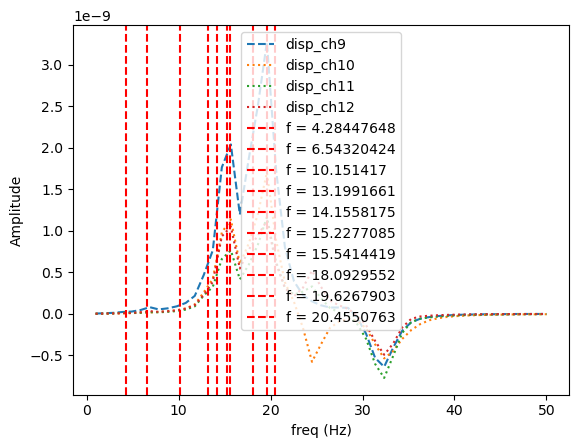

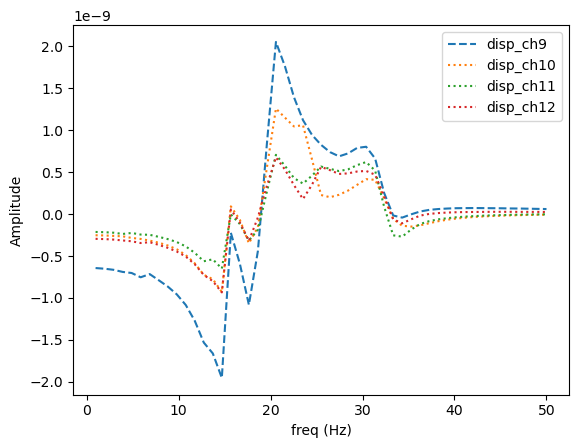

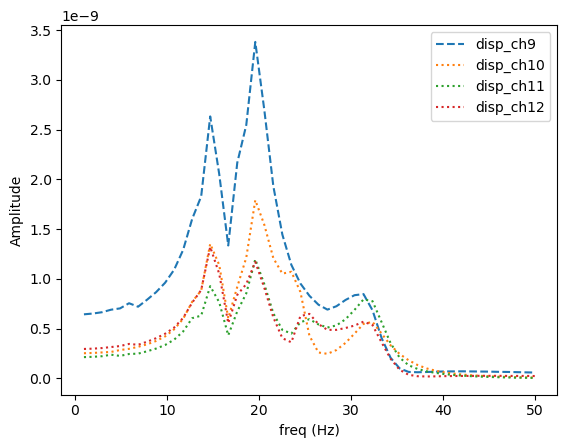

In [36]:
# Visualization
freq_values = meas_FRFs['disp_ch9']['freq']
frf_ampl3 = meas_FRFs['disp_ch9']['imag']
plt.plot(freq_values, frf_ampl3, label="disp_ch9",linestyle="--")
frf_ampl = meas_FRFs['disp_ch10']['imag']
plt.plot(freq_values, frf_ampl, label="disp_ch10",linestyle=":")
frf_ampl = meas_FRFs['disp_ch11']['imag']
plt.plot(freq_values, frf_ampl, label="disp_ch11",linestyle=":")
frf_ampl = meas_FRFs['disp_ch12']['imag']
plt.plot(freq_values, frf_ampl, label="disp_ch12",linestyle=":")

i = 0
for x in natrual_freq:
    if i <= 9:
        plt.axvline(x=x, color='r', linestyle='--', label=f'f = {x}')
    i = i +1


plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Amplitude")
plt.show()

# Visualization
freq_values = meas_FRFs['disp_ch9']['freq']
frf_ampl3 = meas_FRFs['disp_ch9']['real']
plt.plot(freq_values, frf_ampl3, label="disp_ch9",linestyle="--")
frf_ampl = meas_FRFs['disp_ch10']['real']
plt.plot(freq_values, frf_ampl, label="disp_ch10",linestyle=":")
frf_ampl = meas_FRFs['disp_ch11']['real']
plt.plot(freq_values, frf_ampl, label="disp_ch11",linestyle=":")
frf_ampl = meas_FRFs['disp_ch12']['real']
plt.plot(freq_values, frf_ampl, label="disp_ch12",linestyle=":")
i = 0



plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Amplitude")
plt.show()

# Visualization
freq_values = meas_FRFs['disp_ch9']['freq']
frf_ampl3 = meas_FRFs['disp_ch9']['ampl']
plt.plot(freq_values, frf_ampl3, label="disp_ch9",linestyle="--")
frf_ampl = meas_FRFs['disp_ch10']['ampl']
plt.plot(freq_values, frf_ampl, label="disp_ch10",linestyle=":")
frf_ampl = meas_FRFs['disp_ch11']['ampl']
plt.plot(freq_values, frf_ampl, label="disp_ch11",linestyle=":")
frf_ampl = meas_FRFs['disp_ch12']['ampl']
plt.plot(freq_values, frf_ampl, label="disp_ch12",linestyle=":")


plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Amplitude")
plt.show()





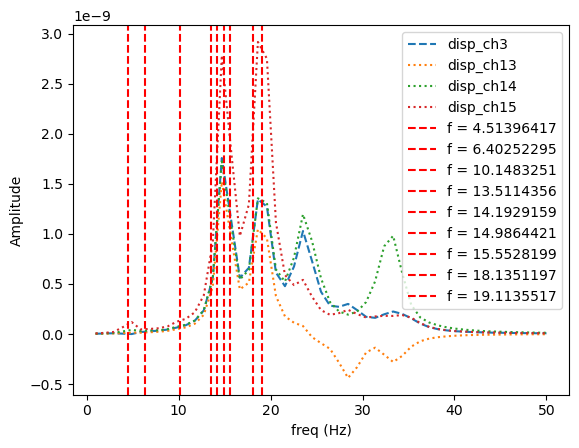

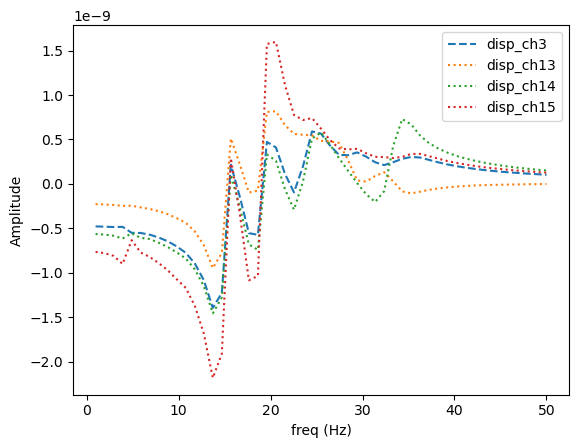

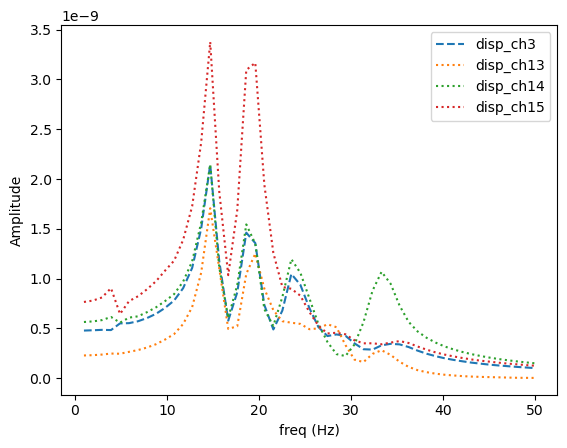

In [25]:
# Visualization
freq_values = meas_FRFs['disp_ch3']['freq']
frf_ampl3 = meas_FRFs['disp_ch3']['imag']
plt.plot(freq_values, frf_ampl3, label="disp_ch3",linestyle="--")
frf_ampl = meas_FRFs['disp_ch13']['imag']
plt.plot(freq_values, frf_ampl, label="disp_ch13",linestyle=":")
frf_ampl = meas_FRFs['disp_ch14']['imag']
plt.plot(freq_values, frf_ampl, label="disp_ch14",linestyle=":")
frf_ampl = meas_FRFs['disp_ch15']['imag']
plt.plot(freq_values, frf_ampl, label="disp_ch15",linestyle=":")


i = 0
for x in natrual_freq:
    if i <= 8:
        plt.axvline(x=x, color='r', linestyle='--', label=f'f = {x}')
    i = i +1



plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Amplitude")
plt.show()


# Visualization
freq_values = meas_FRFs['disp_ch3']['freq']
frf_ampl3 = meas_FRFs['disp_ch3']['real']
plt.plot(freq_values, frf_ampl3, label="disp_ch3",linestyle="--")
frf_ampl = meas_FRFs['disp_ch13']['real']
plt.plot(freq_values, frf_ampl, label="disp_ch13",linestyle=":")
frf_ampl = meas_FRFs['disp_ch14']['real']
plt.plot(freq_values, frf_ampl, label="disp_ch14",linestyle=":")
frf_ampl = meas_FRFs['disp_ch15']['real']
plt.plot(freq_values, frf_ampl, label="disp_ch15",linestyle=":")



plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Amplitude")
plt.show()

# Visualization
freq_values = meas_FRFs['disp_ch3']['freq']
frf_ampl3 = meas_FRFs['disp_ch3']['ampl']
plt.plot(freq_values, frf_ampl3, label="disp_ch3",linestyle="--")
frf_ampl = meas_FRFs['disp_ch13']['ampl']
plt.plot(freq_values, frf_ampl, label="disp_ch13",linestyle=":")
frf_ampl = meas_FRFs['disp_ch14']['ampl']
plt.plot(freq_values, frf_ampl, label="disp_ch14",linestyle=":")
frf_ampl = meas_FRFs['disp_ch15']['ampl']
plt.plot(freq_values, frf_ampl, label="disp_ch15",linestyle=":")
i = 0

#for x in natrual_freq:
#    if i == 5 or i == 8:
#        plt.axvline(x=x, color='r', linestyle='--', label=f'f = {x}')
#    i = i +1

plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Amplitude")
plt.show()





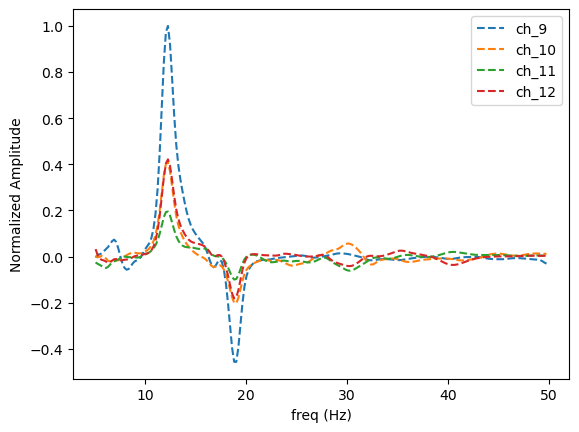

NameError: name 'i_model_1OG_norm' is not defined

In [37]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os

i_file = 13
#i_pos = 3
i_pos_2OG = [3,13,14,15]
i_pos_1OG = [9,10,11,12]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/max_i

#plt.plot(f,i, label=f"ch_{i_pos}",linestyle="--")
#plt.legend()
#plt.xlabel("freq (Hz)")
#plt.ylabel("Amplitude")
#plt.show()


for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

for i in range(4):
    i_pos = i_pos_1OG[i]
    i_norm = i_model_1OG_norm[i,:]
    plt.plot(freq_values,i_norm, label=f"ch_{i_pos}",linestyle="--")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()




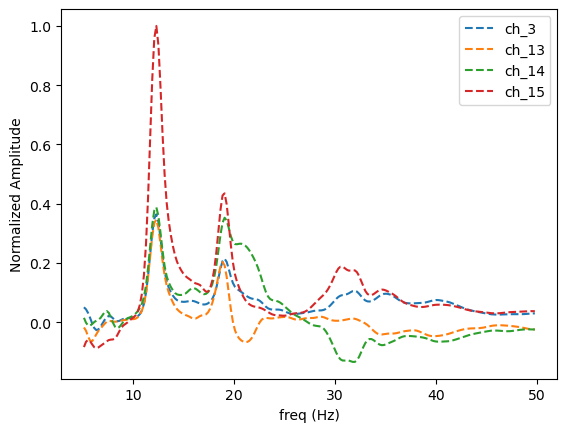

NameError: name 'i_model_2OG_norm' is not defined

In [38]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os

i_file = 13
#i_pos = 3
i_pos_2OG = [3,13,14,15]
i_pos_1OG = [9,10,11,12]
cut_freq_low = 5
cut_freq_high = 50

f_2OG  = []
r_2OG  = []
i_2OG  = []
for i in range(4):
    i_pos = i_pos_2OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_2OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_2OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_2OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_2OG_mat = np.vstack(f_2OG)
    r_2OG_mat = np.vstack(r_2OG)
    i_2OG_mat = np.vstack(i_2OG)
    

max_i = np.max(abs(i_2OG_mat))
i_2OG_mat_norm = i_2OG_mat/max_i


for i in range(4):
    i_pos = i_pos_2OG[i]
    f_ = f_2OG_mat[i,:]
    i_norm = i_2OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()



for i in range(4):
    i_pos = i_pos_2OG[i]
    i_norm = i_model_2OG_norm[i,:]
    plt.plot(freq_values,i_norm, label=f"ch_{i_pos}",linestyle="--")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

In [ ]:
mode_shpae_vector_exp = np.zeros()

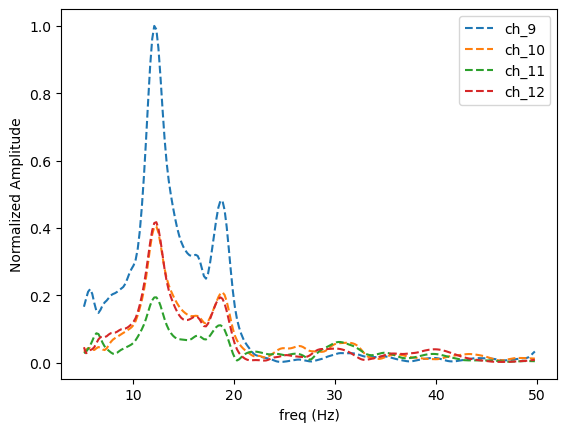

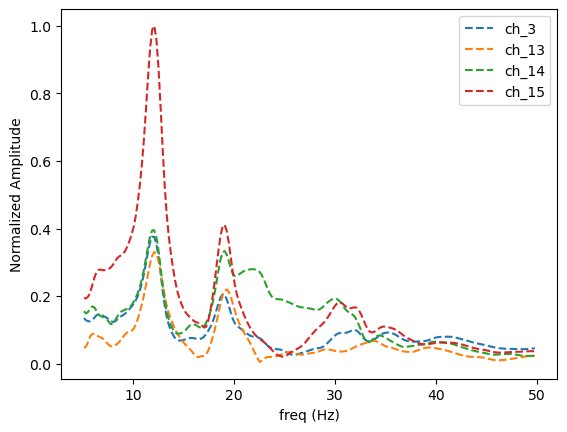

In [53]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os
from scipy.signal import find_peaks

i_file = 13
#i_pos = 3
i_pos_2OG = [3,13,14,15]
i_pos_1OG = [9,10,11,12]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []
f_2OG  = []
r_2OG  = []
i_2OG  = []
ampl_1OG = []
ampl_2OG = []
peaks_list_1OG = []
peaks_list_2OG = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)
    ampl_1OG.append(np.sqrt(np.power(i.reshape(1, -1),2)+np.power(r.reshape(1, -1),2))) 

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    a_1OG_mat = np.vstack(ampl_1OG)
    
max_a = np.max(abs(a_1OG_mat))
a_1OG_mat_norm = a_1OG_mat/max_a
max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/max_i


for i in range(4):
    i_pos = i_pos_2OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_2OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_2OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_2OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)
    ampl_2OG.append(np.sqrt(np.power(i.reshape(1, -1),2)+np.power(r.reshape(1, -1),2))) 

    f_2OG_mat = np.vstack(f_2OG)
    r_2OG_mat = np.vstack(r_2OG)
    i_2OG_mat = np.vstack(i_2OG)
    a_2OG_mat = np.vstack(ampl_2OG)

max_a = np.max(abs(a_2OG_mat))
a_2OG_mat_norm = a_2OG_mat/max_a
max_i = np.max(abs(i_2OG_mat))
i_2OG_mat_norm = i_2OG_mat/max_i


for i in range(a_2OG_mat_norm.shape[0]):
    peaks, _ = find_peaks(a_2OG_mat_norm[i,:])
    peaks_list_2OG.append(peaks)




for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = a_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


for i in range(4):
    i_pos = i_pos_2OG[i]
    f_ = f_2OG_mat[i,:]
    i_norm = a_2OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


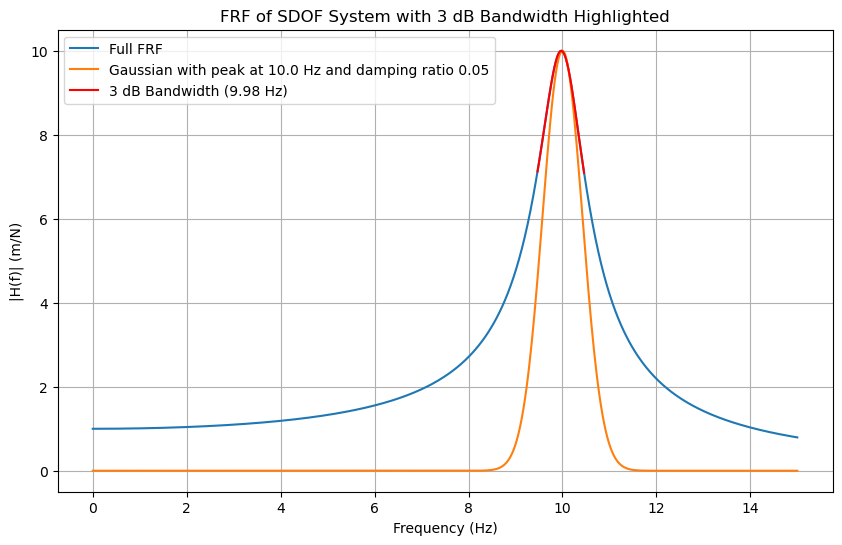

3 dB Bandwidth is between 9.47 Hz and 10.46 Hz.


In [165]:
import numpy as np
import matplotlib.pyplot as plt

# Define system and frequency parameters
f_n = 10.0  # Natural frequency of the SDOF system (Hz)
zeta = 0.05  # Damping ratio
m = 1.0  # Mass (kg), assumed to be 1 for simplicity

# Define frequency range for FRF calculation
frequencies = np.linspace(0, 15, 500)  # Frequency range in Hz
omega = 2 * np.pi * frequencies  # Angular frequency in rad/s
omega_n = 2 * np.pi * f_n  # Natural angular frequency in rad/s

# Define FRF function for the SDOF system
def compute_frf(omega_n, zeta, omega, m):
    return (1 / m) * (omega_n**2) / ((omega_n**2 - omega**2) + 1j * 2 * zeta * omega_n * omega)

# Calculate the full FRF
H = compute_frf(omega_n, zeta, omega, m)

# Calculate the magnitude of the FRF
H_magnitude = np.abs(H)

# Find the peak of the FRF
peak_value = np.max(H_magnitude)
peak_frequency = frequencies[np.argmax(H_magnitude)]

# Calculate the 3 dB downpoint (0.707 times the peak value)
db_3_value = peak_value / np.sqrt(2)

# Find the indices of frequencies where the FRF is within 3 dB of the peak
indices_3db = np.where(H_magnitude >= db_3_value)[0]
freq_3db_range = frequencies[indices_3db]

# Compute the standard deviation (sigma) based on the damping ratio
sigma = (zeta * f_n) / np.sqrt(2 * np.log(2))

# Define the Gaussian distribution centered at the natural frequency
def gaussian(f, f_n, sigma):
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

# Calculate the Gaussian distribution
gaussian_curve = peak_value*gaussian(frequencies, f_n, sigma)

# Plot the Gaussian distribution



# Plot the original FRF and highlight the 3 dB bandwidth
plt.figure(figsize=(10, 6))

# Plot the full FRF magnitude
plt.plot(frequencies, H_magnitude, label='Full FRF')
plt.plot(frequencies, gaussian_curve, label=f'Gaussian with peak at {f_n} Hz and damping ratio {zeta}')
# Highlight the 3 dB bandwidth
plt.plot(frequencies[indices_3db], H_magnitude[indices_3db], 'r', label=f'3 dB Bandwidth ({peak_frequency:.2f} Hz)')

# Labels and legend
plt.title('FRF of SDOF System with 3 dB Bandwidth Highlighted')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(f)| (m/N)')
plt.legend()
plt.grid()
plt.show()

# Print the 3 dB bandwidth range
print(f"3 dB Bandwidth is between {freq_3db_range[0]:.2f} Hz and {freq_3db_range[-1]:.2f} Hz.")
